In [117]:
from typing import Annotated,Sequence,List,Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv import ArxivQueryRun
from langchain_community.tools.riza.command import ExecPython
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.graph import START,END,StateGraph,MessagesState
from langgraph.prebuilt import create_react_agent

from dotenv import load_dotenv
load_dotenv()

True

In [118]:
# 1 intialize llm

llm =ChatGroq(model='llama-3.3-70b-versatile')

In [119]:
# defineing tools

tool_tavily=TavilySearchResults(max_results=2)

tool_code_interpreter=ExecPython()
tools=[tool_tavily,tool_code_interpreter]

In [120]:
tool_code_interpreter.invoke('give me how many As present in a string of AVYGABAAHKJHDAAAAUHBU?')

'Riza code execution returned a non-zero exit code. The output captured from stderr was:\nTraceback (most recent call last):\n  File "<string>", line 1\n    give me how many As present in a string of AVYGABAAHKJHDAAAAUHBU?\n         ^^\nSyntaxError: invalid syntax\n'

In [121]:
system_prompt = ('''You are a workflow supervisor managing a team of three agents: Prompt Enhancer, Researcher,research papers and Coder. Your role is to direct the flow of tasks by selecting the next agent based on the current stage of the workflow. For each task, provide a clear rationale for your choice, ensuring that the workflow progresses logically, efficiently, and toward a timely completion.

**Team Members**:
1. Enhancer: Use prompt enhancer as the first preference, to Focuse on clarifying vague or incomplete user queries, improving their quality, and ensuring they are well-defined before further processing.
2. Researcher: Specializes in gathering information.
3. research_paper_node: this node helps to gather information about a research paper.
4. Coder: Handles technical tasks related to caluclation, coding, data analysis, and problem-solving, ensuring the correct implementation of solutions.

**Responsibilities**:
1. Carefully review each user request and evaluate agent responses for relevance and completeness.
2. Continuously route tasks to the next best-suited agent if needed.
3. Ensure the workflow progresses efficiently, without terminating until the task is fully resolved.

Your goal is to maximize accuracy and effectiveness by leveraging each agent’s unique expertise while ensuring smooth workflow execution.
''')


class Supervisor(BaseModel):
    # field is used to give additional information fot the literal 
    # : The colon is used to specify the type of the variable (type hinting). It tells us what kind of value this variable is expected to hold.
    next: Literal['enhancer','researcher','research_paper_node','coder']=Field(
        description="specifies the next worker in the pipeline:"
        "'enhancer' for enhancing the user prompt if it is unclear or vague,"
        "'reseracher' for gathering additional information,"
        "'research_paper_node' for gathering information from a research papers on the internet,"
        "'coder' for handling technical tasks such as calculation, coding, data analysis, and problem-solving"
    )

    reason :str =Field(
        description="the reason for the decision,providing context on why a particular worker was chosen"
    )

In [122]:
def supervisor_node(state:MessagesState) -> Command[Literal['enhancer','researcher','research_paper_node','coder']]:
    """
    supervisor node for routing tasks based on the current state and llm response .
    Agrs:
        state (MessageState): the current state containing message history.
    returns:
        Command: A command indicatingthe next state or action
    """

    messages=[
        {'role':'system','content':system_prompt},
    ]+state["messages"]# state['message]- it is the message while taling to the llm

    response = llm.with_structured_output(Supervisor).invoke(messages)
    goto=response.next

    reason=response.reason

    print(f"Current Node:Supervisor -> Goto:{goto}")
    return Command(
        update={
            "messages":[HumanMessage(content=reason,name='supervisor')],
        },
        goto=goto
    )

In [123]:
def enhancer_node(state:MessagesState)->Command[Literal['supervisor']]:
    """
    Enhancer node for refining and clarifying user inputs.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the enhanced query and route back to the supervisor.
    """
    system_prompt = (
        "You are an advanced query enhancer. Your task is to:\n"
        "Don't ask anything to the user, select the most appropriate prompt"
        "1. Clarify and refine user inputs.\n"
        "2. Identify any ambiguities in the query.\n"
        "3. Generate a more precise and actionable version of the original request.\n"
    )

    messages=[{"role":"system","content":system_prompt},]+state['messages']

    enhanced_query=llm.invoke(messages)

    print("Current node:prompt Enhancer -> goto:supervisor")
    return Command(
        update={
            "message":[HumanMessage(content=enhanced_query.content,name="enhancer")]
        },
        goto="supervisor"
    )

In [124]:
def research_node(state:MessagesState)->Command[Literal['validator']]:
    """
    Research node for leveraging a ReAct agent to process research-related tasks.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """

    research_agent=create_react_agent(
        llm,
        tools=[tool_tavily],
        state_modifier="You are a researcher. Focus on gathering information and generating content. Do not perform any other tasks"
    )

    result=research_agent.invoke(state)

    return Command(
        update={
            "messages":[HumanMessage(content=result['messages'][-1].content,name='research_node')],
        },
        goto='validator'
    )

In [125]:
def research_paper_node(state:MessagesState)-> Command[Literal['validator']]:
    """
    Research node for leveraging a ReAct agent to process research-related tasks.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """
    paper_name=llm.invoke(f"you are a name idetifier bot you responsiblity is to identify the name of the research paper in the entire context of this message just return back the name{state['messages'][-1].content}")
    loader = ArxivLoader(
    query=paper_name.content,
    load_max_docs=2
    )
    docs = loader.get_summaries_as_docs()
    result=docs[0]
   
    result=llm.invoke(f"Sumamrize this research paper{result}")
    return Command(
        update={
            "messages":[HumanMessage(content=result.content,name='research_paper_node')],
        },
        goto='validator'
    )

In [126]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
    Coder node for leveraging a ReAct agent to process analyzing, solving math questions, and executing code.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """
    # Create a specialized ReAct agent for coding and problem-solving tasks
    code_agent = create_react_agent(
        llm,
        tools=[tool_code_interpreter],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical caluclations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    # Invoke the agent with the current state to process the input and perform its task
    result = code_agent.invoke(state)

    # Debug logging to trace responses and node transitions
    print(f"Current Node: Coder -> Goto: validator")
    # print(f"Response:", result)

    # Return a command to update the state and move to the 'validator' node
    return Command(
        update={
            "messages": [
                # Append the last message (agent's response) to the state, tagged with "coder"
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        # Specify the next node in the workflow: "validator"
        goto="validator",
    )


In [127]:
system_prompt = '''
You are a workflow validator. Your task is to ensure the quality of the workflow. Specifically, you must:
- Review the user's question (the first message in the workflow).
- Review the answer (the last message in the workflow).
- If the answer satisfactorily addresses the question, signal to end the workflow.
- If the answer is inappropriate or incomplete, signal to route back to the supervisor for re-evaluation or further refinement.
Ensure that the question and answer match logically and the workflow can be concluded or continued based on this evaluation.

Routing Guidelines:
1. 'supervisor' Agent: For unclear or vague state messages.
2. Respond with 'FINISH' to end the workflow.
'''


class validator(BaseModel):
    next:Literal['supervisor','FINISH']=Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )

    reason:str=Field(
        description="Reason for the decison"
    )


In [128]:
def validator_node(state:MessagesState)-> Command[Literal['supervisor','__end__']]:
    """
    Validator node for checking if the question and the answer are appropriate.

    Args:
        state (MessagesState): The current state containing message history.

    Returns:
        Command: A command indicating whether to route back to the supervisor or end the workflow.
    """
    user_query=state['messages'][0].content
    agent_query=state['messages'][-1].content
    messages=[{"role":"system","content":system_prompt},
              {"role":'user','content':user_query},
              {"role":'assistant','content':agent_query}
    ]
    result=llm.with_structured_output(validator).invoke(messages)
    goto=result.next
    reason=result.reason

    if goto=='FINISH' or goto==END:
        goto=END
        print("Trasisiton to end")

    else:
        print("Trasition to supervisor")


    print(f"Current Node:Supervisor -> Goto:{goto}")
    return Command(
        update={
            "messages":[HumanMessage(content=reason,name='validator')]
        },
        goto=goto
    )


In [129]:
# Initialize the StateGraph with MessagesState to manage the flow of messages between nodes
builder = StateGraph(MessagesState)


builder.add_node("supervisor", supervisor_node)  # Add the supervisor node to the graph
# Add task-specific nodes for various roles in the multi-agent system
builder.add_node("enhancer", enhancer_node)  # Node for refining and clarifying user inputs
builder.add_node("researcher", research_node)  # Node for handling research-related tasks
builder.add_node("coder", code_node)  # Node for managing coding and analytical tasks
builder.add_node("research_paper_node",research_paper_node)
builder.add_node("validator", validator_node)  # Node for managing coding and analytical tasks

# Add edges and nodes to define the workflow of the graph
builder.add_edge(START, "supervisor")  # Connect the start node to the supervisor node

# Compile the graph to finalize its structure
graph = builder.compile()


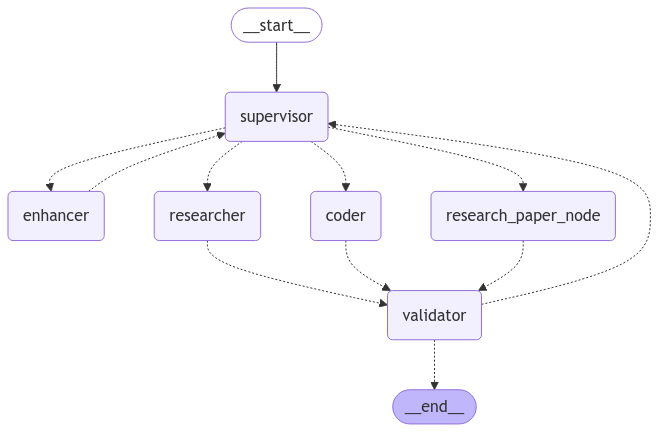

In [130]:

from IPython.display import Image, display # Import for displaying images in a Jupyter Notebook

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [131]:

import pprint

inputs = {
    "messages": [
        ("user", "give me details about the paper lipnet"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()
     

Current Node:Supervisor -> Goto:research_paper_node
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user is asking for details about a specific research paper, 'LipNet', which requires gathering information from research papers on the internet.", additional_kwargs={}, response_metadata={}, name='supervisor', id='a5ca8544-c814-4abd-826a-816780e53392')]}

"Output from node 'research_paper_node':"
{ 'messages': [ HumanMessage(content="This research paper introduces LipNet, a deep learning model for lipreading that can decode text from the movement of a speaker's mouth at the sentence level. Unlike previous approaches that focused on word-level classification, LipNet is an end-to-end trainable model that uses spatiotemporal convolutions, a recurrent network, and the connectionist temporal classification loss to map a sequence of video frames to text. The model is trained entirely end-to-end and achieves state-of-the-art results on the GRID corpus, with a 95.2% ac

In [132]:
inputs = {
    "messages": [
        ("user", "Research the impact of climate change on agriculture in Southeast Asia. Based on your findings, propose potential solutions to mitigate its effects on crop production"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node:Supervisor -> Goto:researcher
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's question requires gathering additional information on the impact of climate change on agriculture in Southeast Asia to provide a comprehensive answer.", additional_kwargs={}, response_metadata={}, name='supervisor', id='fa38b5eb-c83c-4156-a3b7-292cfd18562e')]}

"Output from node 'researcher':"
{ 'messages': [ HumanMessage(content='<function=tavily_search_results_json[]{"query": "solutions to mitigate climate change effects on agriculture in Southeast Asia"}</function>', additional_kwargs={}, response_metadata={}, name='research_node', id='c268200c-d1d9-40c3-9f0c-c8877cc65919')]}

Trasisiton to end
Current Node:Supervisor -> Goto:__end__
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The research has been conducted and potential solutions have been proposed to mitigate the effects of climate change on crop production in Southeast Asia.', add